In [35]:
from functools import partial
from itertools import product
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import SoilsDataset
from umap import UMAP
from scipy.spatial.distance import cdist
from skbio.stats.distance import bioenv, DistanceMatrix, mantel


In [36]:
soils_data = SoilsDataset('data/soils')
tree = soils_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [37]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)

soil_mf = soils_data['metadata']
soil_table = soils_data['table']
metadata = soil_mf.set_index('sample_name')
soil_table = soil_table.filter(metadata.index)
table = min_count_filter.fit_transform(soil_table)
metadata = metadata.loc[table.ids('sample')]

In [38]:
metadata.columns

Index(['annual_season_precpt', 'annual_season_temp', 'anonymized_name',
       'carb_nitro_ratio', 'cmin_rate', 'collection_date', 'country', 'depth',
       'description', 'dna_extracted', 'elevation', 'env_biome', 'env_feature',
       'host_subject_id', 'latitude', 'longitude', 'ph',
       'physical_specimen_remaining', 'project_name', 'public',
       'qiita_study_id', 'sample_type', 'silt_clay', 'soil_moisture_deficit',
       'soil_type', 'specific_location', 'texture', 'title', 'tot_org_carb',
       'tot_org_nitro'],
      dtype='object')

In [39]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [40]:
rarefied_table

5650 x 88 <class 'biom.table.Table'> with 23456 nonzero entries (4% dense)

In [41]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [42]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

In [43]:
clr_table = aitchison_pipeline.fit_transform(table)
X_to_ordinate = cdist(clr_table, clr_table)
if (X_to_ordinate != X_to_ordinate.T).any() and np.allclose(
        X_to_ordinate, X_to_ordinate.T):
    indices = np.tril_indices(len(X_to_ordinate))
    X_to_ordinate[indices] = X_to_ordinate.T[indices]
dm = DistanceMatrix(cdist(X_to_ordinate, X_to_ordinate), ids=table.ids())

In [44]:
numeric_metadata = metadata.select_dtypes(include=['number'])
nunique = numeric_metadata.apply(pd.Series.nunique)
cols_to_drop = nunique.loc[nunique <= 1].index
numeric_metadata = numeric_metadata.drop(cols_to_drop, axis=1)

In [45]:
bioenv(dm, numeric_metadata)

,size,correlation
vars,,
ph,1,0.777701
"ph, soil_moisture_deficit",2,0.681948
"carb_nitro_ratio, ph, soil_moisture_deficit",3,0.622623
"annual_season_temp, carb_nitro_ratio, ph, soil_moisture_deficit",4,0.583909
"annual_season_precpt, annual_season_temp, carb_nitro_ratio, ph, soil_moisture_deficit",5,0.553823
"annual_season_precpt, annual_season_temp, carb_nitro_ratio, ph, silt_clay, soil_moisture_deficit",6,0.524453
"annual_season_precpt, annual_season_temp, carb_nitro_ratio, longitude, ph, silt_clay, soil_moisture_deficit",7,0.500341
"annual_season_precpt, annual_season_temp, carb_nitro_ratio, elevation, longitude, ph, silt_clay, soil_moisture_deficit",8,0.477938
"annual_season_precpt, annual_season_temp, carb_nitro_ratio, elevation, longitude, ph, silt_clay, soil_moisture_deficit, tot_org_carb",9,0.460108


In [46]:
bioenv(dm, numeric_metadata, columns=['ph']).correlation[0]

0.7777008918069424

In [47]:
bioenv_results = []
for column in numeric_metadata.columns:
    bioenv_correlation = bioenv(
        dm,
        numeric_metadata,
        columns=[column],
    ).correlation[0]
    bioenv_results.append({
        'var': column,
        'correlation': bioenv_correlation,
    })

In [48]:
pd.DataFrame(
    bioenv_results
).sort_values('correlation', ascending=False)

,var,correlation
7,ph,0.777701
9,soil_moisture_deficit,0.390812
0,annual_season_precpt,0.323261
6,longitude,0.250918
10,tot_org_carb,0.169030
5,latitude,0.168629
2,carb_nitro_ratio,0.151843
11,tot_org_nitro,0.126265
8,silt_clay,0.087780
1,annual_season_temp,0.084445


In [49]:
def UmapPCA(metric, min_dist=0.15, n_neighbors=15, random_state=None,
            n_components=2):
    return Pipeline([
        ('umap', UMAP(metric=metric,
                      min_dist=min_dist,
                      n_neighbors=n_neighbors,
                      n_components=n_components,
                      random_state=random_state,
                      )),
        ('pca', PCA()),
    ])

In [50]:
def pcoa_amend_axes(transformer, axes_names):
    pe = transformer.ordination_.proportion_explained
    return [f'{axn} ({pexp:.1%})' for pexp, axn in zip(pe, axes_names)]

In [51]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
        'axes': ['PCoA-1', 'PCoA-2'],
        'amend_axes': pcoa_amend_axes,
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            n_neighbors=80,
            random_state=825,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2'],
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            n_neighbors=15,
            random_state=724,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2'],
    },
    {
        'method': 'UMAP\nNeighbors=87',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            n_neighbors=87,
            random_state=724,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2'],
    },
]

In [52]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    amend_axes = emb.get('amend_axes', lambda t, labels: labels)
    results[(name, method)] = {'ordination': result,
                               'axes': amend_axes(transformer, emb['axes']),
                               }


In [53]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns


In [54]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}


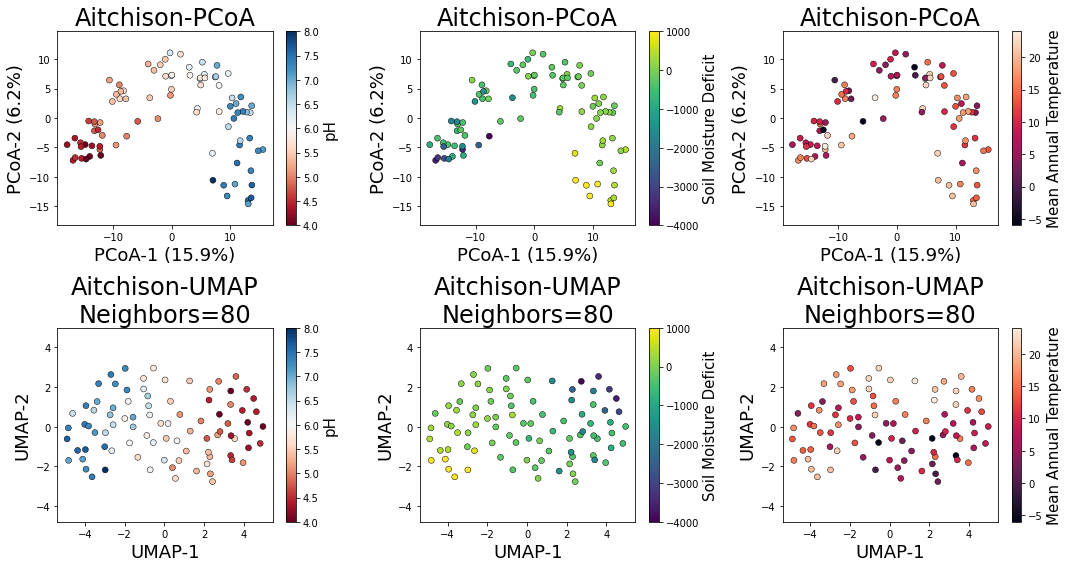

In [55]:
class AxesWrapper:

    def __init__(self, nrows, ncols, axs, transpose=False):
        self.axs = axs
        self.nrows = nrows
        self.ncols = ncols
        self.transpose = transpose

    def __getitem__(self, pos):
        x, y = pos
        if self.nrows == 1 and self.ncols == 1:
            return self.axs
        elif self.nrows == 1:
            return self.axs[x]
        elif self.ncols == 1:
            return self.axs[y]
        elif self.transpose:
            return self.axs[y][x]
        else:
            return self.axs[x][y]


def subplots_wrapper(nrows, ncols, *args, transpose=False, **kwargs):
    fig, axs = plt.subplots(nrows, ncols, *args, **kwargs)
    return fig, AxesWrapper(nrows, ncols, axs, transpose=transpose)

fig, axs = subplots_wrapper(2, 3,
                            figsize=(15, 8),
                            transpose=True,
                            )
hue_var = 'ph'
cs1 = "RdBu"
hue2 = 'soil_moisture_deficit'
cs2 = "viridis"
hue3 = 'annual_season_temp'
cs3 = "rocket"
POINT_SIZE = 35

keep_keys = {
    ('Aitchison', 'PCoA'),
    ('Aitchison', 'UMAP\nNeighbors=80'),
}

filtered_results = {key: val for key, val in results.items() if key in
                    keep_keys}
for (name, method), result in filtered_results.items():
        j = h_position_map[method]
        res = result['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        norm = mpl.colors.Normalize(vmin=4, vmax=8)
        cmap = sns.color_palette(cs1, as_cmap=True)
        ph_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue_var,
            data=res,
            ax=axs[[0, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs1,
            cmap=ph_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(ph_mapper, ax=g)
        cbar.ax.set_ylabel('pH', fontsize=15)

        norm = mpl.colors.Normalize(vmin=-4000, vmax=1000)
        cmap = sns.color_palette(cs2, as_cmap=True)
        temp_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue2,
            data=res,
            ax=axs[[1, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs2,
            cmap=temp_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)
        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(temp_mapper, ax=g)
        cbar.ax.set_ylabel('Soil Moisture Deficit', fontsize=15)


        norm = mpl.colors.Normalize(vmin=-6, vmax=24)
        cmap = sns.color_palette(cs3, as_cmap=True)
        temp_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue3,
            data=res,
            ax=axs[[2, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs3,
            cmap=temp_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)
        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(temp_mapper, ax=g)
        cbar.ax.set_ylabel('Mean Annual Temperature', fontsize=15)


plt.tight_layout()
plt.savefig(f'results/2.0-real-data-soil-ordination-Aitchison-{hue_var}-{hue2}'
            f'-{hue3}.svg')
plt.show()



In [56]:

def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import CCA, PLSCanonical
from scipy.spatial.distance import cdist
import numpy as np


In [58]:
target_var = 'ph'
class mock_result:
    correlation = 0

    def __getitem__(self, item):
        return 0

all_correlations = []
for (name, method), result in results.items():
    target = metadata[target_var]

    first_component = result['ordination']['PC1']
    for category in metadata.columns:
        target = metadata[category]
        sr2 = spearmanr(target, first_component)
        all_correlations.append({
            'name': name,
            'PC': 1,
            'method': method,
            'category': category,
            'spearmanr': sr2.correlation,
            'p-value': sr2[1],
        })

    second_component = result['ordination']['PC2']

    secondary_gradients = [None, mock_result()]
    for category in metadata.columns:
        secondary_target = metadata[category]
        if np.issubdtype(secondary_target, np.number):
            sr2 = pearsonr(secondary_target, second_component)
            all_correlations.append({
                'name': name,
                'method': method,
                'PC': 2,
                'category': category,
                'spearmanr': sr2[0],
                'p-value': sr2[1],
            })
            if abs(sr2[0]) > abs(secondary_gradients[1][0]):
                secondary_gradients = [category, sr2]

    # print(name, method, spearmanr(target, first_component))
    # print(name, method, secondary_gradients)

/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [59]:
corr_df = pd.DataFrame(all_correlations).query(
    "("
    "name == 'Aitchison' "
    " and "
    "("
    "(category == 'annual_season_temp') "
    "or (category == 'ph'))"
    "or (category == 'soil_moisture_deficit')"
    ")"
    " and (method != 'UMAP\\nNeighbors=15')"
    ""
).sort_values(by=['category', 'PC'])

corr_df['spearmanr'] = corr_df['spearmanr'].round(3)

corr_df['method'] = corr_df['method'].str.replace('\n', ' ')

In [60]:
corr_df

,name,PC,method,category,spearmanr,p-value
1,Aitchison,1,PCoA,annual_season_temp,0.173,1.065143e-01
45,Aitchison,1,UMAP Neighbors=80,annual_season_temp,-0.184,8.546464e-02
133,Aitchison,1,UMAP Neighbors=87,annual_season_temp,0.218,4.172186e-02
31,Aitchison,2,PCoA,annual_season_temp,-0.313,2.998123e-03
75,Aitchison,2,UMAP Neighbors=80,annual_season_temp,0.478,2.467961e-06
163,Aitchison,2,UMAP Neighbors=87,annual_season_temp,-0.604,4.799123e-10
16,Aitchison,1,PCoA,ph,0.934,2.872925e-40
60,Aitchison,1,UMAP Neighbors=80,ph,-0.931,2.434330e-39
148,Aitchison,1,UMAP Neighbors=87,ph,0.928,1.567943e-38
38,Aitchison,2,PCoA,ph,-0.104,3.330142e-01


In [61]:
spearmanr(filtered_results[('Aitchison', 'PCoA')]['ordination']['PC3'],
          metadata['annual_season_temp'])

SpearmanrResult(correlation=-0.5683012084081738, pvalue=7.678724302294202e-09)

In [62]:
filtered_results[('Aitchison', 'PCoA')]['ordination'].corrwith\
    (metadata['annual_season_temp'], method='spearman').abs().max()

/home/garmstro/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0.5683012084081739